In [0]:
# Filtado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

# **SOLUCION**

Librerias

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Acceso a Drive

In [38]:
from google.colab import drive
from os import chdir
    
drive.mount('/content/drive/', force_remount=True)
chdir("/content/drive/My Drive/evaluacion-felondonoa")

Mounted at /content/drive/


Cargar Datos

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues, keras=False):
    cm = confusion_matrix(y_true, y_pred)
    if keras:
        classes = classes[unique_labels(y_true, y_pred)]
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [43]:
df = pd.read_csv(
    f'sms-spam.csv',
    sep = ',',
    thousands = None,
    decimal = '.',
    encoding='latin-1')

df.head()

,tipo,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [44]:
##
## Verifica la lectura de los datos
##
df.describe()

,tipo,text
count,5574,5574
unique,2,5160
top,ham,"Sorry, I'll call later"
freq,4827,30


In [46]:
##
## Se obtiene la cantidad de casos para
## cada tipo de mensaje.
##
df.tipo.value_counts()

ham     4827
spam     747
Name: tipo, dtype: int64

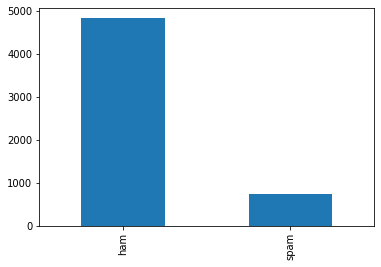

In [47]:
df.tipo.value_counts().plot.bar();

In [48]:
##
## Se convierte el conteo anterior en probabilidades.
##
round(100 * df.tipo.value_counts() / sum(df.tipo.value_counts()), 1)

ham     86.6
spam    13.4
Name: tipo, dtype: float64

In [49]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

df['stemmed'] = df.text.apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split() ]))

df.head(10)

,tipo,text,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win FA cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so earli hor... U c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I don't think he goe to usf, he live aroun..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darl it' been 3 week' now an...
6,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,As per your request 'mell mell (oru minnaminun...
8,spam,WINNER!! As a valued network customer you have...,winner!! As a valu network custom you have bee...
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobil 11 month or more? U R entitl to...


In [50]:
##
## Matriz de términos del documento en Python
##
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=True,            # Los valores distintos de cero son fijados en 1
    min_df=5                # ignora palabras con baja freq
)


##
## Aplica la función al texto
##
dtm = count_vect.fit_transform(df.stemmed)

##
## Las filas contienen los mensajes
## y las clomunas los términos
##
dtm.shape

(5574, 1540)

In [51]:
##
## Palabras aprendidas de los mensajes de texto
##
vocabulary = count_vect.get_feature_names()
len(vocabulary)

1540

In [52]:
##
## Primeras palabras del vocabulario
##
vocabulary[0:10]

['00',
 '000',
 '02',
 '03',
 '04',
 '06',
 '0800',
 '08000839402',
 '08000930705',
 '0870']

In [53]:

##
## Recupera los mensajes de la dtm
##
def dtm2words(dtm, vocabulary, index):
    as_list = dtm[index,:].toarray().tolist()
    docs = []
    for i in index:
        k = [vocabulary[iword] for iword, ifreq in enumerate(as_list[i]) if ifreq > 0]
        docs += [k]
    return docs

for i, x in enumerate(dtm2words(dtm, vocabulary, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])):
    print('Org: ', df.text[i])
    print('Mod: ', ' '.join(x))
    print('')

Org:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Mod:  avail bugi cine got great la onli point wat world

Org:  Ok lar... Joking wif u oni...
Mod:  joke lar ok wif

Org:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Mod:  appli comp cup entri final free question rate receiv std text txt win wkli

Org:  U dun say so early hor... U c already then say...
Mod:  alreadi dun earli say

Org:  Nah I don't think he goes to usf, he lives around here though
Mod:  don goe live nah think usf

Org:  FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
Mod:  50 darl freemsg fun hey like ok send std week word xxx

Org:  Even my brother is not like to speak with me. They treat me like aids patent.
Mod:  brother like speak treat

Or

Se dividen los datos en entrenamiento y prueba

In [0]:
##
## Creación de los conjuntos de entrenamiento y prueba.
##
X_train      = dtm[0:4168,]
X_test       = dtm[4169:,]
y_train_true = df.tipo[0:4168]
y_test_true  = df.tipo[4169:]

In [57]:

##
## Distribución de los datos en el conjunto de entrenamiento.
##
round(100 * y_train_true.value_counts() / sum(y_train_true.value_counts()), 1)

ham     86.5
spam    13.5
Name: tipo, dtype: float64

In [58]:
##
## Distribución de los datos en el conjunto de entrenamiento.
##
round(100 * y_test_true.value_counts() / sum(y_test_true.value_counts()), 1)

ham     87.0
spam    13.0
Name: tipo, dtype: float64

Se entrena el modelo

In [59]:

##
## Entrena el modelo
##
##
## Se importa la libreria
##
from sklearn.naive_bayes import BernoulliNB

##
## Se crea un clasificador Naive Bayes (NB)
##
clf = BernoulliNB()

##
## Se entrena el clasificador
##
clf.fit(X_train.toarray(), y_train_true)
clf

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Se evalua modelo

In [60]:

##
## Se pronostica para los datos de prueba.
##
y_test_pred = clf.predict(X_test.toarray())
y_test_pred_prob = clf.predict_proba(X_test.toarray())
y_test_pred

array(['spam', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [61]:
##
## Métricas de desempeño
##
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = y_test_true,
                 y_pred = y_test_pred)

array([[1217,    5],
       [  20,  163]])

In [62]:
%%R -i y_test_true -i y_test_pred
##
## Se calcula la matriz de confusión.
##
table(y_test_true, y_test_pred)

           y_test_pred
y_test_true  ham spam
       ham  1217    5
       spam   20  163


In [63]:
%%R
##
## Para el análisis resulta mejor construir la
## matriz de confusión
##
# install.packages("gmodels")
##
library(gmodels)
CrossTable(y_test_pred,
           y_test_true,
           prop.chisq = FALSE,
           prop.t = FALSE,
           dnn = c('predicted', 'actual'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1405 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1217 |        20 |      1237 | 
             |     0.984 |     0.016 |     0.880 | 
             |     0.996 |     0.109 |           | 
-------------|-----------|-----------|-----------|
        spam |         5 |       163 |       168 | 
             |     0.030 |     0.970 |     0.120 | 
             |     0.004 |     0.891 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1222 |       183 |      1405 | 
             |     0.870 |     0.130 |           | 
-------------|-----------|-----------|-----------|

 


In [64]:
clf.predict_proba(X_test.toarray())

array([[6.63801021e-15, 1.00000000e+00],
       [9.99629498e-01, 3.70501972e-04],
       [9.99665501e-01, 3.34499235e-04],
       ...,
       [9.99991808e-01, 8.19235717e-06],
       [9.99937801e-01, 6.21994279e-05],
       [9.99977784e-01, 2.22158366e-05]])

In [65]:

##
## Resulta más conveniente preparar una nueva tabla que
## muestre la clasificación y no únicamente las
## probabilidades.
##
results = pd.DataFrame(data = {
    'actual_type':  y_test_true,
    'predict_type': y_test_pred,
    'prob_ham':     [v[0] for v in y_test_pred_prob],
    'prob_spam':    [v[1] for v in y_test_pred_prob]})

results.head(5)

,actual_type,predict_type,prob_ham,prob_spam
4169,spam,spam,6.638010e-15,1.000000e+00
4170,ham,ham,9.996295e-01,3.705020e-04
4171,ham,ham,9.996655e-01,3.344992e-04
4172,ham,ham,1.000000e+00,2.050868e-09
4173,ham,ham,9.999999e-01,6.130877e-08


In [66]:
##
## Mensajes con clasificación errónea.
## Resulta muy importante determinar porque los
## mensajes están mal clasificados
##
results[results['actual_type'] != results['predict_type']]

,actual_type,predict_type,prob_ham,prob_spam
4213,spam,ham,0.999475,0.000525
4249,spam,ham,0.761034,0.238966
4256,spam,ham,0.970804,0.029196
4297,spam,ham,0.727760,0.272240
4298,spam,ham,0.631022,0.368978
4344,ham,spam,0.353753,0.646247
4373,spam,ham,0.992271,0.007729
4394,spam,ham,0.989344,0.010656
4399,ham,spam,0.389774,0.610226
4514,spam,ham,0.999772,0.000228


In [67]:

##
## Sin embargo, es mucho más intersante extraer
## mensajes con probabilidades numéricamente
## cercanas a 0.5. Estos podrían generar ambiguedad
## en la clasificación.
##
results[(results['prob_spam'] > 0.4) & (results['prob_spam'] < 0.6)]

,actual_type,predict_type,prob_ham,prob_spam
4253,ham,ham,0.517533,0.482467
4931,spam,spam,0.463595,0.536405
5326,ham,ham,0.564854,0.435146
5372,spam,ham,0.537354,0.462646
5379,spam,ham,0.586516,0.413484


In [68]:
##
## Mensajes mal clasificados con probabilidad cercana a 0.5
##
results[(results['prob_spam'] > 0.4) &
        (results['prob_spam'] < 0.6) &
        (results['actual_type'] != results['predict_type'])]

,actual_type,predict_type,prob_ham,prob_spam
5372,spam,ham,0.537354,0.462646
5379,spam,ham,0.586516,0.413484


In [69]:
# Conversion del campo "Clasificacion" a binario para poder usarlo con scikit learn
df['tipo'] = df.tipo.map({'ham':0, 'spam':1})
df

,tipo,text,stemmed
0,0,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. avail onli in b..."
1,0,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win FA cup fina...
3,0,U dun say so early hor... U c already then say...,U dun say so earli hor... U c alreadi then say...
4,0,"Nah I don't think he goes to usf, he lives aro...","nah I don't think he goe to usf, he live aroun..."
...,...,...,...
5569,1,This is the 2nd time we have tried 2 contact u...,thi is the 2nd time we have tri 2 contact u. U...
5570,0,Will Ã¼ b going to esplanade fr home?,will Ã¼ b go to esplanad fr home?
5571,0,"Pity, * was in mood for that. So...any other s...","pity, * wa in mood for that. so...ani other su..."
5572,0,The guy did some bitching but I acted like i'd...,the guy did some bitch but I act like i'd be i...


In [70]:
#Preparar datos para regresión
count_vector = CountVectorizer()
texto = count_vector.fit_transform(df.stemmed).toarray()
print(texto)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [74]:
#Separar datos de test y train
XL_train, XL_test, yL_train, yL_test = train_test_split(texto, df['tipo'], random_state=4)
print ('Train set:', XL_train.shape,  yL_train.shape)
print ('Test set:', XL_test.shape,  yL_test.shape)

Train set: (4180, 8293) (4180,)
Test set: (1394, 8293) (1394,)


In [77]:
#Regresión Lineal
LR = LogisticRegression(C=0.01, solver='liblinear').fit(XL_train,yL_train)

#Predicción del modelo 
yhat = LR.predict(XL_test)
yhat

from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(yL_test, yhat)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.9418938307030129

La predicción es aproximadamente 1 lo que indica que las predicciones halladas son reales

In [79]:
#Matriz de Confusionsin normalizar
cnf_matrix = confusion_matrix(yL_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

print(cnf_matrix)

[[ 118   81]
 [   0 1195]]


In [0]:
#Pendiente implementar Clasificador - Red Neuronal